# Padaria Portugesa Geolocation

In [93]:
# classic import
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gp
import matplotlib.pyplot as plt

In [40]:
# change projection to meters
freguesias = gp.read_file('data/freguesias.shp').to_crs('EPSG:3763')
padarias = pd.read_csv('data/padarias.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [88]:
padarias.shape[0]

63

In [41]:
freguesias = freguesias[['NOME', 'AREA_M2', 'geometry']]

In [66]:
points = gp.GeoDataFrame(padarias, geometry=gp.points_from_xy(padarias['restaurant.location.longitude'], padarias['restaurant.location.latitude']))
points.crs = {'init' :'epsg:4326'}

points = points.to_crs('EPSG:3763')

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


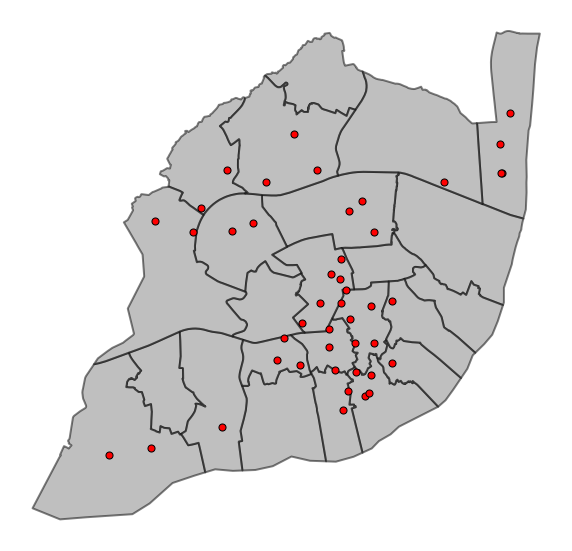

In [97]:
# get exterior of multipolygons
exterior = freguesias.unary_union
    
# remove points outside the city
points = points[points.geometry.within(exterior)]
           
# plot figure to see input data
#ax = gplt.polyplot(freguesias, figsize=(10, 10), lw= .5, facecolor= 'none', edgecolor='k', alpha=1, projection=gcrs.Mercator());

base = freguesias.plot(figsize=(10, 10), facecolor='grey', edgecolor='black', linewidth= 2, alpha=.5)
points.plot(ax=base, marker='o', color='red', markersize=50, edgecolor='k', linewidth=1)
base.axis('off');

In [65]:
points

IndexError: too many indices for array

Empty GeoDataFrame
Columns: [restaurant.R.has_menu_status.delivery, restaurant.R.has_menu_status.takeaway, restaurant.R.res_id, restaurant.apikey, restaurant.id, restaurant.name, restaurant.url, restaurant.location.address, restaurant.location.locality, restaurant.location.city, restaurant.location.city_id, restaurant.location.latitude, restaurant.location.longitude, restaurant.location.zipcode, restaurant.location.country_id, restaurant.location.locality_verbose, restaurant.switch_to_order_menu, restaurant.cuisines, restaurant.timings, restaurant.average_cost_for_two, restaurant.price_range, restaurant.currency, restaurant.highlights, restaurant.offers, restaurant.opentable_support, restaurant.is_zomato_book_res, restaurant.mezzo_provider, restaurant.is_book_form_web_view, restaurant.book_form_web_view_url, restaurant.book_again_url, restaurant.thumb, restaurant.user_rating.aggregate_rating, restaurant.user_rating.rating_text, restaurant.user_rating.rating_color, restaurant.user_ratin

In [22]:
points['restaurant.user_rating.aggregate_rating']

0     4.1
1     3.8
2     3.9
3     4.0
4     3.8
5     4.1
6     3.8
7     3.9
8     4.0
9     3.4
10    4.0
11    4.0
12    3.9
13    3.9
14    3.9
15    3.8
16    4.0
17    3.9
18    3.9
19    3.4
0     3.7
1     3.9
2     2.7
3     3.7
4     2.7
5     2.2
6     3.7
7     3.7
9     3.8
13    3.8
15    3.0
16    3.8
17    3.1
18    3.8
19    3.6
2     3.9
3     2.7
4     3.4
8     3.0
10    3.5
14    3.3
17    0.0
19    3.3
0     4.0
6     0.0
Name: restaurant.user_rating.aggregate_rating, dtype: float64

In [29]:
freguesias.crs['units']

KeyError: 'units'

In [78]:
freguesias[freguesias['NOME'] == 'Santo António']['geometry'].area

0    1.494327e+06
dtype: float64

In [ ]:
1494348.58